# Sentiment Analysis from Tweets

This NLP task implements functions for a text classifier, which aims to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split. 


P.S. It is recommended to read the project report included in the repository associated with this notebook to understand the theory and motivation behind the techniques implemented below.

In [ ]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [8]:
from src.data_parser import *

from src.preprocess_module import *

from src.training import *

from src.metrics import *

In [5]:
raw_data = []          
train_data = []         
test_data = []          

data_file_path = f'{PROJECT_ROOT}/data/raw/sentiment-dataset.tsv'
raw_data = load_data(data_file_path) 
print("Loaded %d rawDatapoints" % (len(raw_data)),
      "Preparing the dataset...\n",sep='\n')

Loaded 33540 rawDatapoints
Preparing the dataset...



## 4a) Pre-processing and perform train_test split:
 
## Lexicons & Dictionaries
- **_load_lexicon(path)**: reads sentiment wordlists (Bing Liu format; ignores `;` comments) → `POS_LEXICON`, `NEG_LEXICON`.
- **CONTRACTIONS / SLANG**: maps common contractions/slang to expanded forms.
- **STOPWORDS / NEGATION_WORDS**: supports selective stopword removal and negation handling.
- **CONTRASTIVE_CONNECTIVES / SENTENCE_BOUNDARIES**: mark contrastive scopes (e.g., after “but”, “however”).
 

## High-Level Preprocess Pipeline
 
1. Cleaning: unicode → URLs → hashtags → convert emojis → lowercase → digits removal.
2. Normalisation: Replace slang.
3. Tokenise 
4. Lemmatize
5. Additional features: Add bigrams → add lexicon tokens 


# Predict labels given a classifier and train-test split


In [7]:
# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)

unique_labels = list(set([label for (text, label) in raw_data]) )
print("Now %d rawDatapoints" % (len(raw_data)),
      "Preparing training and test data...\n",sep='\n')

train_data, test_data = train_test_split_data(raw_data = raw_data, percentage= 0.8)

print("After split, %d rawData, %d trainData, %d testData\n" % (len(raw_data), len(train_data), len(test_data)) )

Now 33540 rawDatapoints
Preparing training and test data...

After split, 33540 rawData, 26832 trainData, 6708 testData



## 4b) Improved model architecture: 

## Vectorisation (FeatureUnion)
- **Word TF–IDF**: `TfidfVectorizer(tokenizer=pre_process)`  
  *Uses our full preprocessing pipeline to emit tokens (incl. bigrams/lexicon tags).*
- **Char TF–IDF**: `TfidfVectorizer(analyzer="char", ngram_range=(3, 5))`  
  *Captures subword patterns, misspellings, and morphology.*


## Pipeline Stages
1. **Vectoriser**: FeatureUnion(Word TF–IDF ⊕ Char TF–IDF)
2. **Classifier**: `LinearSVC(max_iter=3000)`
3. **Returns** a fitted `sklearn.pipeline.Pipeline` 


In [8]:
print(test_data[0])   # have a look at the first test data instance
classifier = train_classifier(train_data)
vectorizer =  classifier.named_steps['vectorizer']
global_feature_dict = vectorizer.get_feature_names_out() 

print("After split, %d rawData, %d trainData, %d testData\n" % (len(raw_data), len(train_data), len(test_data)),
"\nTraining Samples: ", len(train_data), "\nFeatures:" , len(global_feature_dict))


x_test = [text for (text, label) in test_data]

test_pred = predict_label_from_raw_sklearn(x_test, classifier)       
test_true= [label for (text, label) in test_data]

final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
print("Done training!\n")
print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])


("Tomorrow we'll release our 58th episode of #HSonAir profiling our very own @AlissaDosSantos ! We'll talk about storytelling and Beyonce!", 'positive')


After split, 33540 rawData, 26832 trainData, 6708 testData
 
Training Samples:  26832 
Features: 961711
Done training!

Precision: 0.883191
Recall: 0.883721
F Score:0.883394


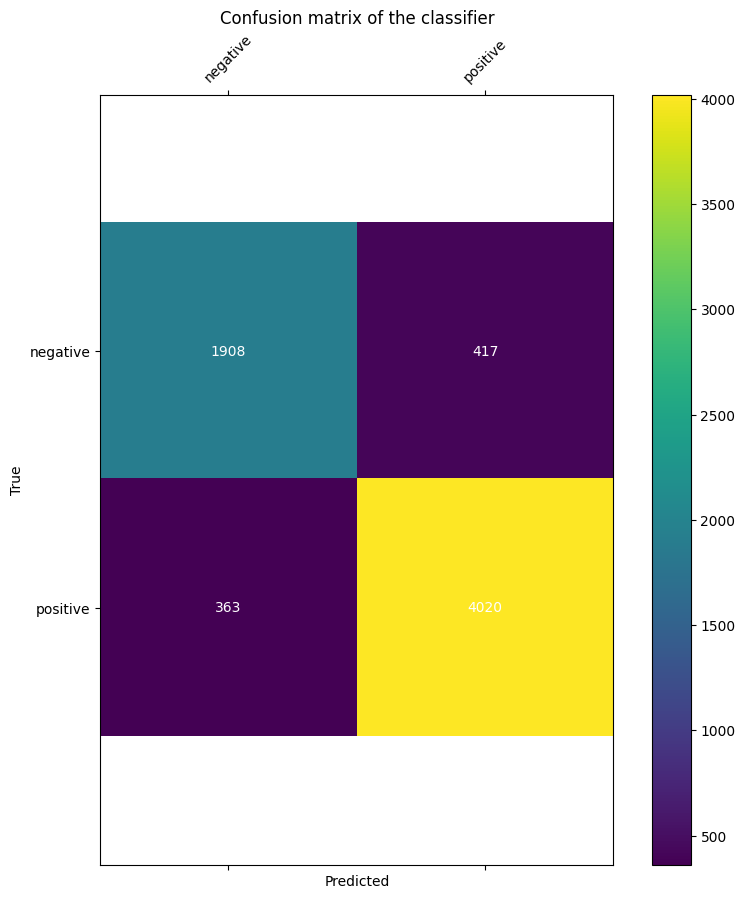

In [9]:
confusion_matrix_heatmap(test_true, test_pred, labels = unique_labels)

## Cross Validation

In [10]:
cross_val_avg_scores = cross_validate(train_data, 10)  

print("Precision: %f\nRecall: %f\nF Score:%f" % cross_val_avg_scores[:3])

c:\Users\aprog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\aprog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\aprog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\aprog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\aprog\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: Use

Precision: 0.884048
Recall: 0.884797
F Score:0.884190


c:\Users\aprog\OneDrive\Documents\Git_repos\BERTweet-Sentiment-Classifier\training.py:254: RuntimeWarning: Mean of empty slice
  arr = np.array([[np.nan if v is None else v for v in row] for row in results])


## Precision: 0.885963

## Recall: 0.886849

## F Score: 0.886020